<a href="https://colab.research.google.com/github/asupraja3/ml-ng-notebooks/blob/main/Sigmoid_LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Optional Lab: Sigmoid Function & Logistic Regression

*Adapted, self-contained notebook inspired by Andrew Ng's Machine Learning Specialization.*

In this ungraded lab, you will:
- Explore the **sigmoid** (logistic) function.
- See how **logistic regression** uses the sigmoid to map a linear model into probabilities in \([0,1]\).



## Tools

We will use:
- **NumPy** for scientific computing.
- **Matplotlib** for plotting.
- **scikit-learn** for a simple logistic regression model.


In [ ]:

# === Setup ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# If running outside classic Jupyter, you might need: %matplotlib inline
np.set_printoptions(precision=4, suppress=True)


## Sigmoid (Logistic) Function

For classification, we want outputs between **0 and 1** (interpretable as probabilities).  
The **sigmoid** function maps any real-valued input $z$ maps to $g(z) \in (0,1)$:

$$
g(z) = \frac{1}{1 + e^{-z}}
$$

- As $z \to -\infty$, $g(z) \to 0$  
- As $z \to +\infty$, $g(z) \to 1$

Below, we implement it and try array/scalar inputs.


In [ ]:

# --- Exponential demo (like in-course walkthrough) ---

# Input is an array
input_array = np.array([1, 2, 3])
exp_array = np.exp(input_array)
print("Input to exp:", input_array)
print("Output of exp:", exp_array)

# Input is a single number (scalar)
input_val = 1.0
exp_val = np.exp(input_val)
print("Input to exp:", input_val)
print("Output of exp:", exp_val)


Input to exp: [1 2 3]
Output of exp: [ 2.7183  7.3891 20.0855]
Input to exp: 1.0
Output of exp: 2.718281828459045


In [ ]:

# --- Sigmoid implementation ---
def sigmoid(z):
    """
    Vectorized sigmoid function.
    Works for:
      - Scalars (single number)
      - 1D arrays (vectors)
      - N-dimensional arrays (matrices, tensors)

    Formula:
        sigmoid(z) = 1 / (1 + exp(-z))

    Purpose:
        - Maps any real-valued number into the range (0, 1)
        - Used in logistic regression to interpret model output as probability

    This implementation improves numerical stability for large |z| values
    to prevent overflow/underflow when computing exp(-z).
    """

    # Convert input to NumPy array of floats (ensures consistent behavior)
    z = np.array(z, dtype=float) # [-6. -3. -1.  0.  1.  3.  6.]

    # Allocate output array with same shape/type as z
    out = np.empty_like(z, dtype=float) #out:  [-6. -3. -1.  0.  1.  3.  6.]

    # Boolean mask: positions where z >= 0 (positive or zero values)
    pos = z >= 0 #Egs pos:  [False False False  True  True  True  True]

    # Boolean mask: positions where z < 0 (negative values)
    neg = ~pos  # "~" is bitwise NOT → flips True/False
    #neg:  [ True  True  True False False False False]

    # ---------------------------------------------------------
    # Case 1: z >= 0
    # Regular formula works fine here without overflow risk
    # ---------------------------------------------------------
    out[pos] = 1.0 / (1.0 + np.exp(-z[pos])) #[pos] returns only the elements of out where pos is True.

    # ---------------------------------------------------------
    # Case 2: z < 0
    # For large negative z, exp(-z) overflows (too large)
    # So we rewrite the sigmoid:
    #   sigmoid(z) = 1 / (1 + exp(-z))
    #              = exp(z) / (1 + exp(z))
    # This form avoids computing exp(-z) for large |z|
    # ---------------------------------------------------------
    ez = np.exp(z[neg]) #Notice theres no minus"-" To avoid large numbers of ez

    #[neg] returns only the elements of out where neg is True.
    out[neg] = ez / (1.0 + ez) # same formula rearranged to avoid overlfow or blowup

    # Return array of same shape as z, each value in (0, 1)
    return out

# Try sigmoid with array & scalar
z_array = np.array([-6, -3, -1, 0, 1, 3, 6], dtype=float)
print("z array:", z_array)
print("sigmoid(z array):", sigmoid(z_array))

z_scalar = -2.0
print("z scalar:", z_scalar, " -> sigmoid(z):", float(sigmoid(z_scalar)))


z array: [-6. -3. -1.  0.  1.  3.  6.]
sigmoid(z array): [0.0025 0.0474 0.2689 0.5    0.7311 0.9526 0.9975]
z scalar: -2.0  -> sigmoid(z): 0.11920292202211755


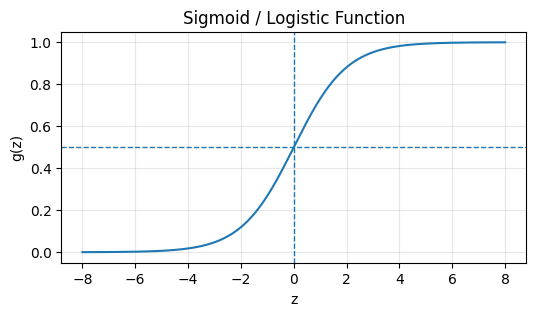

In [ ]:

# --- Plot the sigmoid curve ---

# Create an array of 400 evenly spaced values between -8 and 8
# np.linspace(start, stop, num_points):
#   - start = -8   → lower bound of z
#   - stop = 8     → upper bound of z
#   - num_points = 400 → number of equally spaced samples
# This range covers both large negative, near-zero, and large positive inputs,
# allowing us to see the full "S" shape of the sigmoid.
z = np.linspace(-8, 8, 400)

# Apply the sigmoid function to each value in z
#   - Since our sigmoid is vectorized, it will process the whole array at once.
#   - g will be the same shape as z (400 values), each in the range (0, 1).
#   - For large negative z → g ~ 0
#   - For z = 0 → g = 0.5
#   - For large positive z → g ~ 1
g = sigmoid(z)


plt.figure(figsize=(6, 3))
plt.plot(z, g)
plt.axvline(0, linestyle='--', linewidth=1)
plt.axhline(0.5, linestyle='--', linewidth=1)
plt.xlabel("z")
plt.ylabel("g(z)")
plt.title("Sigmoid / Logistic Function")
plt.ylim(-0.05, 1.05)
plt.grid(True, alpha=0.3)
plt.show()


## Logistic Regression

A logistic regression model applies the sigmoid to the familiar linear model:

$$
f_{w,b}(x) = g(w^\top x + b), \quad \text{where} \quad g(z) = \frac{1}{1+e^{-z}}
$$

- The term $z = w^\top x + b$ is a **linear regression** output.  
- Passing $z$ through the **sigmoid** yields a **probability**: $P(y=1 \mid x)$.  
- The usual decision rule is: predict **1** if $f_{w,b}(x) \ge 0.5$, else **0**.


In [ ]:
# --- Small 1D classification dataset (tumor size -> malignant?) ---

# Feature values (tumor sizes in cm, for example)
# Each number represents the size of a tumor.
# We use float values for consistency in ML workflows.
x_train = np.array([0., 1., 2., 3., 4., 5.])

# Labels: 0 = benign tumor, 1 = malignant tumor
# First three tumors are benign, last three are malignant.
y_train = np.array([0, 0, 0, 1, 1, 1])

# ------------------------------------------------------
# Reshape the feature array into shape (m, 1)
#   - m = number of training examples (here: 6)
#   - 1 = number of features (here: tumor size only)
# Why?
#   - scikit-learn expects input features as a 2D array: (m, n_features)
#   - Right now, x_train is shape (6,), which is 1D.
#   - reshape(-1, 1) converts it to shape (6, 1):
#       - -1 tells NumPy to figure out the number of rows automatically.
#       - 1 specifies 1 column (our single feature).
X = x_train.reshape(-1, 1)

# Display the shapes to confirm
print("X shape:", X.shape, "y shape:", y_train.shape)
# Output:
# X shape: (6, 1)  → 6 examples, 1 feature each
# y shape: (6,)    → 6 labels



X shape: (6, 1) y shape: (6,)


w (coef): [[1.1206]] b (intercept): [-2.8018]
Accuracy: 1.0
Confusion Matrix:
 [[3 0]
 [0 3]]
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         3
           1      1.000     1.000     1.000         3

    accuracy                          1.000         6
   macro avg      1.000     1.000     1.000         6
weighted avg      1.000     1.000     1.000         6



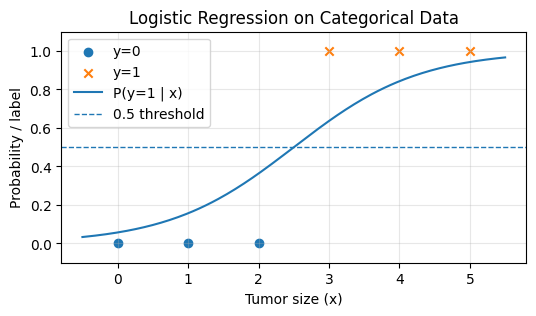

In [ ]:
# --- Fit logistic regression and inspect ---

# 1. Create a LogisticRegression model
# solver='lbfgs':
#   - Optimization algorithm to find the best weights (w) and bias (b)
#   - Works well for small/medium datasets
logreg = LogisticRegression(solver='lbfgs')

# 2. Fit (train) the model on the data
# X: feature matrix of shape (m, 1)
# y_train: labels (0 or 1)
# This finds w and b that minimize the log loss.
logreg.fit(X, y_train)

# ------------------------------------------------------
# 3. Predict probabilities for each training example
# predict_proba(X):
#   - Returns probabilities for both classes in shape (m, 2)
#   - Column 0 = P(y=0 | x)
#   - Column 1 = P(y=1 | x)
# [:, 1] selects only the probability of class 1
proba = logreg.predict_proba(X)[:, 1]

# 4. Apply a 0.5 threshold to convert probabilities to class labels
# If P(y=1) >= 0.5 → predict class 1, else predict class 0
y_pred = (proba >= 0.5).astype(int)

# ------------------------------------------------------
# 5. Inspect model parameters and evaluation metrics

# logreg.coef_ : learned weight(s) for each feature → shape (1, n_features)
# logreg.intercept_ : learned bias term
print("w (coef):", logreg.coef_, "b (intercept):", logreg.intercept_)

# accuracy_score: proportion of correct predictions
print("Accuracy:", accuracy_score(y_train, y_pred))

# confusion_matrix: shows counts of TP, TN, FP, FN
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred))

# classification_report: precision, recall, F1-score for each class
# digits=3 formats numbers to 3 decimal places
print(classification_report(y_train, y_pred, digits=3))

# ------------------------------------------------------
# 6. Prepare data for plotting the probability curve

# Create 200 evenly spaced values in the range:
#   (min feature value - 0.5) to (max feature value + 0.5)
# This ensures the curve extends slightly beyond the training points
xs = np.linspace(x_train.min() - 0.5, x_train.max() + 0.5, 200).reshape(-1, 1)

# Predict probabilities for class 1 at each xs point
# This will be used to draw the smooth sigmoid curve
probs = logreg.predict_proba(xs)[:, 1]


plt.figure(figsize=(6, 3))
plt.scatter(x_train[y_train==0], y_train[y_train==0], marker='o', label='y=0')
plt.scatter(x_train[y_train==1], y_train[y_train==1], marker='x', label='y=1')
plt.plot(xs, probs, label='P(y=1 | x)')
plt.axhline(0.5, linestyle='--', linewidth=1, label='0.5 threshold')
plt.xlabel("Tumor size (x)")
plt.ylabel("Probability / label")
plt.title("Logistic Regression on Categorical Data")
plt.ylim(-0.1, 1.1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



## Notes / Try This

- Notice the orange line in the lecture corresponds to $z = w^\top x + b$, which is **not** a probability by itself.  
- The sigmoid wraps $z$ into $[0,1]$, giving a probability curve.  
- These predictions match the pattern that larger tumors (right side) are more likely to be malignant (label 1).


**Exercises:**
1. Add additional data points near `x=9` or `x=10` (large size) and re-run the notebook. What happens to the curve and predictions?  
2. Change the decision threshold (e.g., 0.3 or 0.7) and observe the effect on predictions.  
3. Compare against a linear regression model with a 0.5 threshold and note the differences in behavior.
